# Елисеев Мирон Вадимович, ПМИ3, ВШЭ-СПб
# Проект по ML.

Использую собственный dataset

## Задача:
Разработать модель машинного обучения, которая предсказывает автора песни на основе её текста и некоторых метаданных на заданном наборе артистов

### Создание датасета с помощью API GENIUS

In [60]:
import pandas as pd
import requests
import time
import lyricsgenius
from collections import defaultdict
import json

import sns

GENIUS_TOKEN = ""

genius = lyricsgenius.Genius(
    GENIUS_TOKEN,
    remove_section_headers=True,
    skip_non_songs=True,
    timeout=15,
    verbose=False
)
genius.verbose = False

artists = [
    "Баста", "Кровосток", "Каста", "CENTR",
    "Гуф", "Птаха", "Смоки Мо", "25/17", "АК-47",
    "Oxxxymiron", "Моргенштерн", "Скриптонит", "FACE", "Элджей",
    "GONE.Fludd", "Markul", "Big Baby Tape", "ATL", "Miyagi",
    "Эндшпиль", "ЛСП", "Boulevard Depo", "T-Fest", "PHARAOH",
    "Дора", "LOVV66", "ANIKV", "Mayot", "SEEMEE", "SODA LUV",
    "Thomas Mraz", "Тимати", "OG Buda",
    "kizaru", "163ONMYNECK", "Yanix", "MORGENSHTERN",
    "MACAN", "LIL KRYSTALLL", "9mice", "kai angel",
    "JEEMBO", "Scally Milano", "SLAVA MARLOW",
    "MAYOT", "Платина", "i61", "SALUKI", "Ежемесячные", "СД", "pyrokinesis",
    "Слава КПСС", "Замай", "FRIENDLY THUG 52 NGG", "madk1d", "тёмный принц", "макулатура",
    "Toxi$", "ICEGERGERT", "Овсянкин"
]

print(f"Всего артистов в списке: {len(artists)}")

Всего артистов в списке: 60


In [61]:
def check_artist_simple(artist_name):
    try:
        search_results = genius.search_artist(artist_name, max_songs=1)
        return {
            'found': True,
            'genius_name': search_results.name,
            'song_count': len(search_results.songs),
            'url': search_results.url
        }
    except Exception as e:
        print(f"Ошибка при проверке {artist_name}: {str(e)[:50]}...")

    return {'found': False}

In [62]:

check_results = []
not_found = []

print("Проверяю артистов на Genius...")
print("=" * 50)

for i, artist in enumerate(artists, 1):
    try:
        result = check_artist_simple(artist)
        result['input_name'] = artist

        if result['found']:
            check_results.append(result)
            print(f"{i:2}. ✅ {artist:25} -> {result['genius_name']:25}")
        else:
            not_found.append(artist)
            print(f"{i:2}. ❌ {artist:25} -> Не найден")

        # Пауза чтобы не спамить API
        time.sleep(0.5)

    except Exception as e:
        print(f"{i:2}.{artist:25} -> Ошибка: {str(e)[:30]}")
        not_found.append(artist)
        time.sleep(1)

print("\n" + "=" * 50)
print(f"Найдено: {len(check_results)} артистов")
print(f"Не найдено: {len(not_found)} артистов")
print(f"Успешность: {len(check_results)/len(artists)*100:.1f}%")


🔍 Проверяю артистов на Genius...
 1. ✅ Баста                     -> Баста (Basta)            
 2. ✅ Кровосток                 -> Кровосток (Krovostok)    
 3. ✅ Каста                     -> Каста (Kasta)            
 4. ✅ CENTR                     -> CENTR                    
 5. ✅ Гуф                       -> Гуф (Guf)                
 6. ✅ Птаха                     -> Птаха (Ptaha)            
 7. ✅ Смоки Мо                  -> Смоки Мо (Smoky Mo)      
 8. ✅ 25/17                     -> 25/17                    
 9. ✅ АК-47                     -> АК-47 (AK-47)            
10. ✅ Oxxxymiron                -> Oxxxymiron               
11. ✅ Моргенштерн               -> НЕ МОРГЕНШТЕРН (NE MORGENSHTERN)
12. ✅ Скриптонит                -> Скриптонит (Skryptonite) 
13. ✅ FACE                      -> FACE                     
14. ✅ Элджей                    -> Элджей (Eldzhey)         
15. ✅ GONE.Fludd                -> GONE.Fludd               
16. ✅ Markul                    -> Markul    

In [63]:
def collect_artist_songs(artist_info, songs_per_artist=30):
    try:
        artist_name = artist_info['genius_name']

        print(f"\nСобираю песни для: {artist_name}")
        print("-" * 40)

        artist = genius.search_artist(
            artist_name,
            max_songs=songs_per_artist,
            sort='popularity',
            get_full_info=False
        )

        if not artist:
            print(f"   ⚠️  Не удалось получить артиста")
            return None

        songs_data = []

        for i, song in enumerate(artist.songs[:songs_per_artist], 1):
            try:
                song_info = {
                    'artist': artist.name,
                    'title': song.title,
                    'url': song.url,
                    'album': song.album if hasattr(song, 'album') else None,
                    'lyrics': song.lyrics,
                    'annotation_count': song.annotation_count,
                    'lyrics_owner_id': song.lyrics_owner_id
                }
                songs_data.append(song_info)

            except Exception as e:
                print(f"   {i:2}. ⚠️  Ошибка с песней: {str(e)[:30]}")
                continue

        return {
            'artist': artist.name,
            'artist_url': artist.url,
            'total_songs_collected': len(songs_data),
            'songs': songs_data
        }

    except Exception as e:
        print(f"   ❌ Ошибка сбора данных: {str(e)[:50]}")
        return None

all_artists_data = []

print("\n" + "=" * 60)
print("НАЧИНАЮ СБОР ПЕСЕН ДЛЯ АРТИСТОВ")
print("=" * 60)

for i, artist_info in enumerate(check_results, 1):
    print(f"\n{i}/{len(check_results)}: {artist_info['input_name']}")

    artist_data = collect_artist_songs(artist_info, songs_per_artist=30)

    if artist_data:
        all_artists_data.append(artist_data)
        print(f"   ✅ Собрано: {artist_data['total_songs_collected']} песен")
    else:
        print(f"   ❌ Не удалось собрать данные")


НАЧИНАЮ СБОР ПЕСЕН ДЛЯ АРТИСТОВ

1/60: Баста

Собираю песни для: Баста (Basta)
----------------------------------------
   ✅ Собрано: 30 песен

2/60: Кровосток

Собираю песни для: Кровосток (Krovostok)
----------------------------------------
   ✅ Собрано: 30 песен

3/60: Каста

Собираю песни для: Каста (Kasta)
----------------------------------------
   ✅ Собрано: 30 песен

4/60: CENTR

Собираю песни для: CENTR
----------------------------------------
   ✅ Собрано: 30 песен

5/60: Гуф

Собираю песни для: Гуф (Guf)
----------------------------------------
   ✅ Собрано: 30 песен

6/60: Птаха

Собираю песни для: Птаха (Ptaha)
----------------------------------------
   ✅ Собрано: 20 песен

7/60: Смоки Мо

Собираю песни для: Смоки Мо (Smoky Mo)
----------------------------------------
   ✅ Собрано: 30 песен

8/60: 25/17

Собираю песни для: 25/17
----------------------------------------
   ✅ Собрано: 30 песен

9/60: АК-47

Собираю песни для: АК-47 (AK-47)
---------------------------------

In [64]:
artist_data = collect_artist_songs(check_results[19], songs_per_artist=30)
all_artists_data.append(artist_data)


Собираю песни для: Эндшпиль (Endspiel)
----------------------------------------


In [65]:
all_artists_data = list(filter(lambda x: x['total_songs_collected'] > 25, all_artists_data))
print("\n" + "=" * 60)

print(f"   Обработано артистов: {len(all_artists_data)}")
print(f"   Всего песен: {sum(a['total_songs_collected'] for a in all_artists_data)}")


   Обработано артистов: 58
   Всего песен: 1740


### Предобработка текста (удаляем stopwords, чистим текст от лишних символов)

In [123]:
import re
import pandas as pd
import json
from datetime import datetime

CAPITAL_STOPWORDS = {
    'Я', 'Ты', 'Он', 'Она', 'Мы', 'Вы', 'Они',
    'Мне', 'Тебе', 'Её', 'Его', 'Нас', 'Вас',
    'Это', 'Там', 'Тут', 'Тогда', 'Когда'
}

def clean_lyrics(lyrics: str) -> list:
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = re.sub(r'\d+Embed', '', lyrics)
    lyrics = '\n'.join(line.strip() for line in lyrics.split('\n'))
    lines = [line for line in lyrics.split('\n') if line.strip()]
    return lines


def extract_capital_words(lines: list) -> list:
    capital_words = []

    for line in lines:
        words = line.split()

        for i, word in enumerate(words):
            clean_word = re.sub(
                r'^[^А-ЯA-Zа-яa-z]+|[^А-ЯA-Zа-яa-z]+$',
                '',
                word
            )

            if not clean_word:
                continue

            if not clean_word[0].isupper():
                continue

            if i == 0:
                continue

            prev_word = words[i - 1]
            if prev_word and prev_word[-1] in '.!?':
                continue

            if clean_word in CAPITAL_STOPWORDS:
                continue

            if clean_word.isupper() and len(clean_word) > 2:
                continue

            if len(clean_word) < 3:
                continue

            capital_words.append(clean_word)

    return capital_words


songs_data = []
removed_zero_lines = 0

for artist_data in all_artists_data:
    artist_name = artist_data['artist']

    for song in artist_data['songs']:
        try:
            lines = clean_lyrics(song['lyrics'])

            if not lines:
                removed_zero_lines += 1
                continue

            lyrics_clean = '\n'.join(lines)

            words = lyrics_clean.replace('\n', ' ').split()
            word_count = len(words)

            annotation_count = song.get('annotation_count', 0)

            capital_words = extract_capital_words(lines)

            capital_count = len(capital_words)
            unique_capital_count = len(set(capital_words))

            song_record = {
                'artist': artist_name,
                'title': song['title'],
                'album': song.get('album', ''),
                'release_date': song.get('release_date', ''),
                'url': song['url'],
                'lyrics': lyrics_clean,

                'word_count': word_count,
                'line_count': len(lines),
                'annotation_count': annotation_count,
                'annotation_density': round(
                    annotation_count / max(word_count, 1), 4
                ),

                'unique_capital_words_count': unique_capital_count,
                'unique_capital_words_ratio': round(
                    unique_capital_count / max(word_count, 1), 4
                )
            }

            songs_data.append(song_record)

        except Exception as e:
            print(f"Ошибка: '{song.get('title', 'Unknown')}': {e}")


df_songs = pd.DataFrame(songs_data)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

csv_filename = 'rap_songs_data_final.csv'
df_songs.to_csv(csv_filename, index=False, encoding='utf-8-sig')

json_filename = 'rap_songs_data_final.json'
output_data = {
    'metadata': {
        'created_at': timestamp,
        'total_songs': len(df_songs),
        'removed_zero_lines': removed_zero_lines,
        'total_artists': df_songs['artist'].nunique(),
        'total_words': int(df_songs['word_count'].sum()),
        'total_annotations': int(df_songs['annotation_count'].sum()),
        'total_unique_capital_words': int(
            df_songs['unique_capital_words_count'].sum()
        )
    },
    'songs': songs_data
}

with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)


print(f"Обработано песен: {len(df_songs)}")
print(f"Удалено песен с 0 строк: {removed_zero_lines}")
print(f"CSV: {csv_filename}")
print(f"JSON: {json_filename}")

Обработано песен: 1716
Удалено песен с 0 строк: 24
CSV: rap_songs_data_final.csv
JSON: rap_songs_data_final.json


Пытаемся выделить два числовых признака: количество уникальных упоминаний в тексте, что является характерной особенностью некоторых артистов, и количество аннотаций в тексте на сайте genius(пытаемся измерить смысловую наполненность)

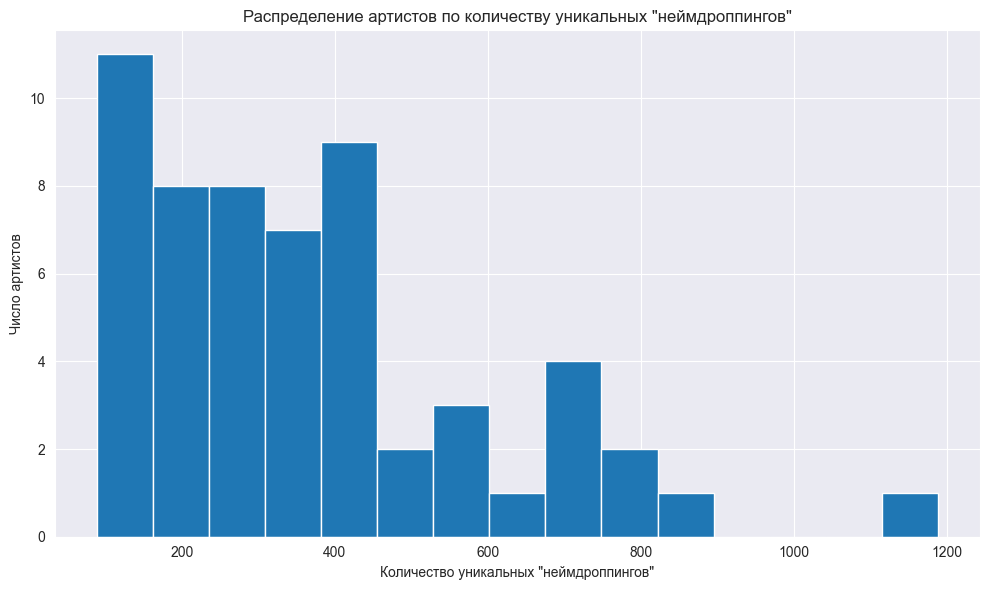

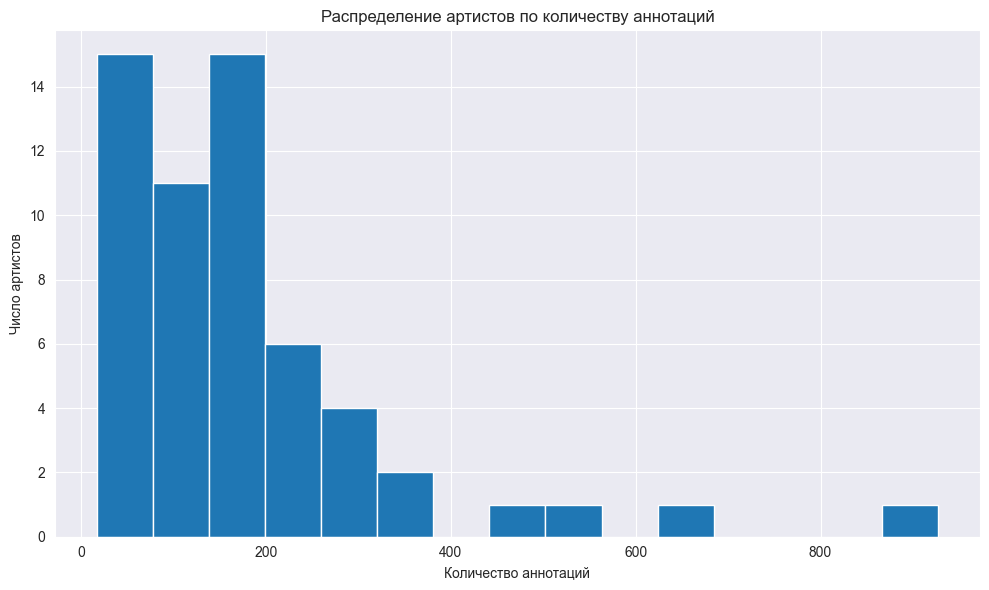

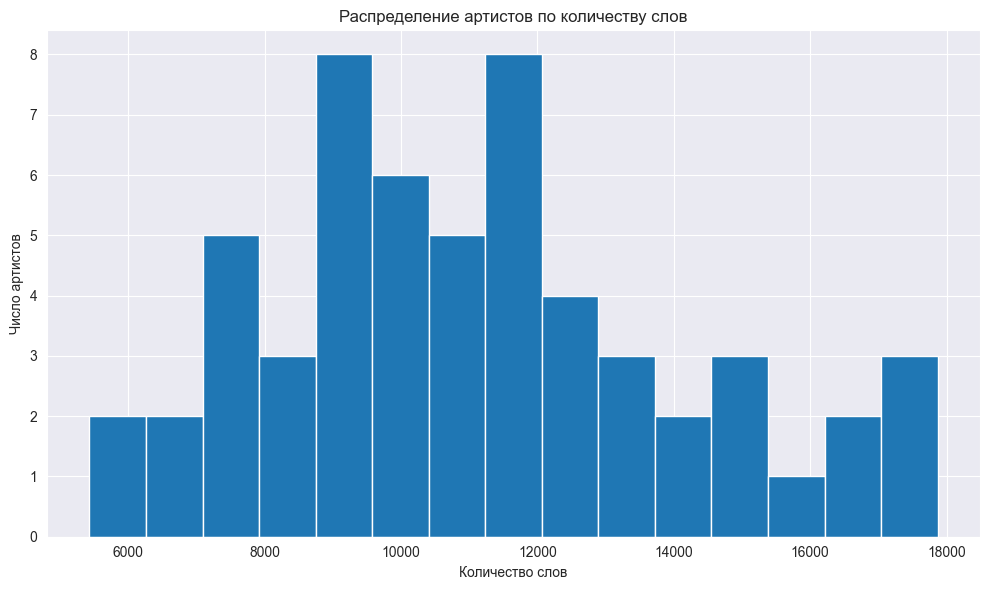

In [225]:
artist_stats = (
    df_songs
    .groupby('artist')
    .agg(
        total_songs=('title', 'count'),
        total_words=('word_count', 'sum'),
        total_unique_capital_words=('unique_capital_words_count', 'sum'),
        average_unique_words_per_song=('unique_capital_words_count', 'sum'),
        total_annotations=('annotation_count', 'sum'),
    )
    .reset_index()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    artist_stats['average_unique_words_per_song'],
    bins=15
)

plt.xlabel('Количество уникальных \"неймдроппингов\"')
plt.ylabel('Число артистов')
plt.title('Распределение артистов по количеству уникальных \"неймдроппингов\"')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(
    artist_stats['total_annotations'],
    bins=15
)

plt.xlabel('Количество аннотаций')
plt.ylabel('Число артистов')
plt.title('Распределение артистов по количеству аннотаций')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(
    artist_stats['total_words'],
    bins=15
)

plt.xlabel('Количество слов')
plt.ylabel('Число артистов')
plt.title('Распределение артистов по количеству слов')

plt.tight_layout()
plt.show()

Видим, что по обоим признакам при увеличении количества падает количество артистов, то есть обилие признака - характерная черта. Более подробную матрицу делать нецелесообразно, так как классов слишком много

### Разделение данных на обучающую и тестовую выборки

In [ ]:

def stratified_artist_split(df, test_size=0.2, random_state=42):
    train_parts = []
    test_parts = []

    for artist, group in df.groupby('artist'):
        train, test = train_test_split(
            group,
            test_size=test_size,
            random_state=random_state
        )
        train_parts.append(train)
        test_parts.append(test)

    return (
        pd.concat(train_parts).sample(frac=1, random_state=random_state),
        pd.concat(test_parts).sample(frac=1, random_state=random_state)
    )
df_train, df_test = stratified_artist_split(df_songs, test_size=0.2)
# разделяем песни каждого артиста равномерно

### Векторизация текста

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_text = tfidf.fit_transform(df_train['lyrics'])
X_test_text = tfidf.transform(df_test['lyrics'])

### Числовые признаки

In [183]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

numeric_features = [
    'annotation_count',
    'unique_capital_words_count',
    'word_count'
]

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(df_train[numeric_features])
X_test_num_scaled = scaler.transform(df_test[numeric_features])

X_train = hstack([X_train_text, X_train_num_scaled])
X_test = hstack([X_test_text, X_test_num_scaled])

y_train = df_train['artist']
y_test = df_test['artist']

print(f"Обучающая выборка: {len(df_train)} образцов")
print(f"Тестовая выборка: {len(df_test)} образцов")
print(f"Размерность признаков: {X_train.shape[1]}")

Обучающая выборка: 1369 образцов
Тестовая выборка: 347 образцов
Размерность признаков: 30003


### Первая попытка обучить модели

In [184]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
)
print("Training LogisticRegression")
lr.fit(X_train, y_train)

svm = LinearSVC()
print("Training LinearSVC")
svm.fit(X_train, y_train)

nb = MultinomialNB()
print("Training MultinomialNB")
nb.fit(X_train_text, y_train)

sgd = SGDClassifier(
    loss='hinge',
    max_iter=1000,
    random_state=42
)
print("Training SGDClassifier")
sgd.fit(X_train, y_train)

LogisticRegression completed


C:\Users\79833\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC completed
MultinomialNB completed
SGDClassifier completed


МЕТРИКИ

In [185]:
def evaluate(model, X, y_true, name):
    y_pred = model.predict(X)
    return {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro')
    }

results = []

results.append(evaluate(lr, X_test, y_test, 'Logistic Regression'))
results.append(evaluate(svm, X_test, y_test, 'Linear SVM'))
results.append(evaluate(sgd, X_test, y_test, 'SGDClassifier'))
results.append(evaluate(nb, X_test_text, y_test, 'Naive Bayes'))

results_df = pd.DataFrame(results).sort_values(
    by='macro_f1',
    ascending=False
)

print(results_df)

                 model  accuracy  macro_f1
1           Linear SVM  0.452450  0.420925
2        SGDClassifier  0.317003  0.299475
0  Logistic Regression  0.242075  0.213853
3          Naive Bayes  0.057637  0.037335


получили неудовлетворительные модели, посмотрим что пошло не так на лучшей модели

In [207]:
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

svm = LinearSVC(max_iter=5000, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))

feature_names = np.concatenate([tfidf.get_feature_names_out(), numeric_features])
coef_df = pd.DataFrame(svm.coef_, columns=feature_names, index=svm.classes_)

# Топ-3 положительных и отрицательных фич для каждого артиста
total = 0
for i in range(len(svm.classes_)):
    result = 0
    top_pos = coef_df.loc[svm.classes_[i]].sort_values(ascending=False).head(10)
    top_neg = coef_df.loc[svm.classes_[i]].sort_values(ascending=True).head(10)
    j = 0
    for k in range(len(all_artists_data)):
        if all_artists_data[k]['artist'] == svm.classes_[i]:
            j = k
    for feature in top_pos.to_dict():
        song_count_for_feature = 0
        for song in all_artists_data[j]['songs']:
            for line in clean_lyrics(song['lyrics']):
                if feature in line.lower():
                    song_count_for_feature += 1
                    break
        if (song_count_for_feature < 2):
            result += 1
    total += result
print(f"Среднее количество важных фич, встречающихся только в одной песне: {total / len(svm.classes_)}")

Accuracy: 0.45244956772334294
Macro F1: 0.42092454163498655
Среднее количество важных фич, встречающихся только в одной песне: 4.578947368421052


Слова, повторяющиеся большое количество раз в одной песне создали шум, поменяем подход, будем смотреть, встречалось слово в тексте или нет

### Обучение большего количества моделей с новым подходом

In [213]:
import pandas as pd
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

# =====================
# 1. Stratified split
# =====================
def stratified_artist_split(df, test_size=0.2, random_state=42):
    train_parts = []
    test_parts = []
    for artist, group in df.groupby('artist'):
        train, test = train_test_split(group, test_size=test_size, random_state=random_state)
        train_parts.append(train)
        test_parts.append(test)
    return pd.concat(train_parts).sample(frac=1, random_state=random_state), \
           pd.concat(test_parts).sample(frac=1, random_state=random_state)

df_train, df_test = stratified_artist_split(df_songs)

# =====================
# 2. TF-IDF (бинарный)
# =====================
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, binary=True)
X_train_counts = vectorizer.fit_transform(df_train['lyrics'])
X_test_counts = vectorizer.transform(df_test['lyrics'])

tfidf = TfidfTransformer(sublinear_tf=True)
X_train_text = tfidf.fit_transform(X_train_counts)
X_test_text = tfidf.transform(X_test_counts)

# =====================
# 3. Числовые признаки
# =====================
numeric_features = ['annotation_count', 'unique_capital_words_count', 'word_count',
                    'unique_capital_words_ratio', 'annotation_density']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(df_train[numeric_features])
X_test_num = scaler.transform(df_test[numeric_features])

# =====================
# 4. Итоговые данные
# =====================
X_train = hstack([X_train_text, X_train_num])
X_test = hstack([X_test_text, X_test_num])
y_train = df_train['artist']
y_test = df_test['artist']

# =====================
# 5. Модели
# =====================
models = {
    'LinearSVC': LinearSVC(max_iter=5000, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=2000, solver='saga', n_jobs=-1),
    'SGDClassifier': SGDClassifier(loss='hinge', max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

results = []

# =====================
# 6. Обучение и результаты на метриках
# =====================
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Train_F1': f1_score(y_train, y_train_pred, average='macro'),
        'Test_F1': f1_score(y_test, y_test_pred, average='macro'),
        'Overfitting_Accuracy': accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred),
        'Overfitting_F1': f1_score(y_train, y_train_pred, average='macro') - f1_score(y_test, y_test_pred, average='macro'),
        'Train_Time': train_time
    })

results_df = pd.DataFrame(results).sort_values('Test_Accuracy', ascending=False)
print("\n=== Summary ===")
print(results_df)

Training LinearSVC...
Training LogisticRegression...
Training SGDClassifier...
Training RandomForest...
Training KNN...

=== Summary ===
                Model  Train_Accuracy  Test_Accuracy  Train_F1   Test_F1  \
0           LinearSVC        1.000000       0.605187  1.000000  0.581677   
3        RandomForest        1.000000       0.435159  1.000000  0.400139   
2       SGDClassifier        0.824690       0.319885  0.865054  0.310419   
1  LogisticRegression        0.750183       0.244957  0.753074  0.207127   
4                 KNN        0.374726       0.164265  0.347020  0.136295   

   Overfitting_Accuracy  Overfitting_F1  Train_Time  
0              0.394813        0.418323    6.548788  
3              0.564841        0.599861    1.696162  
2              0.504805        0.554636    0.372409  
1              0.505226        0.545947   38.593784  
4              0.210461        0.210724    0.005016  


### Визуализация результатов

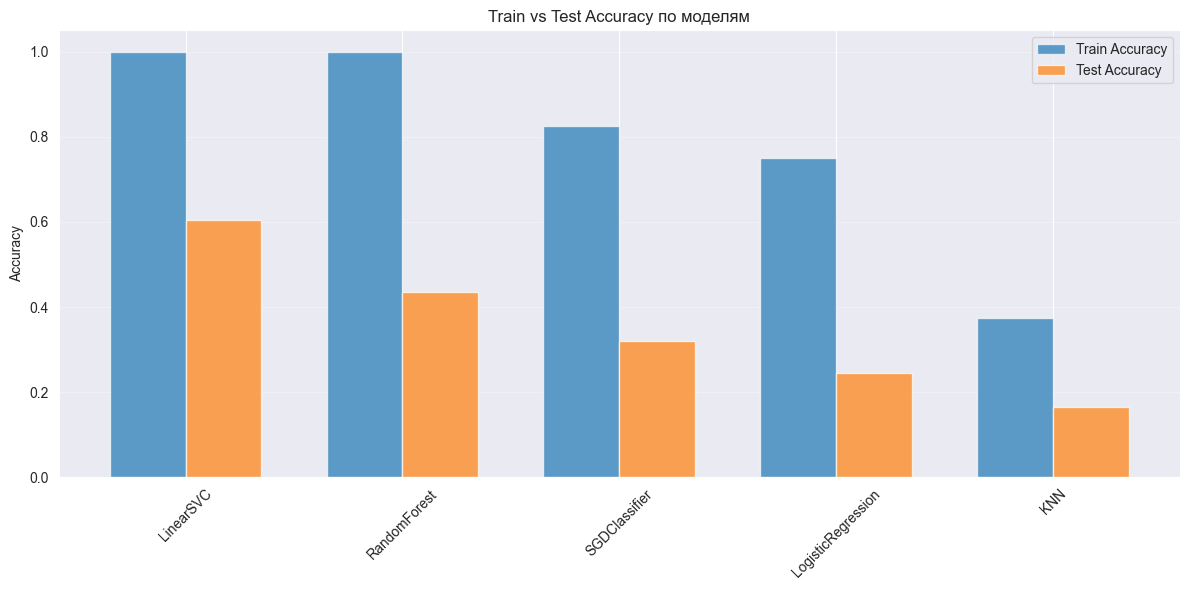

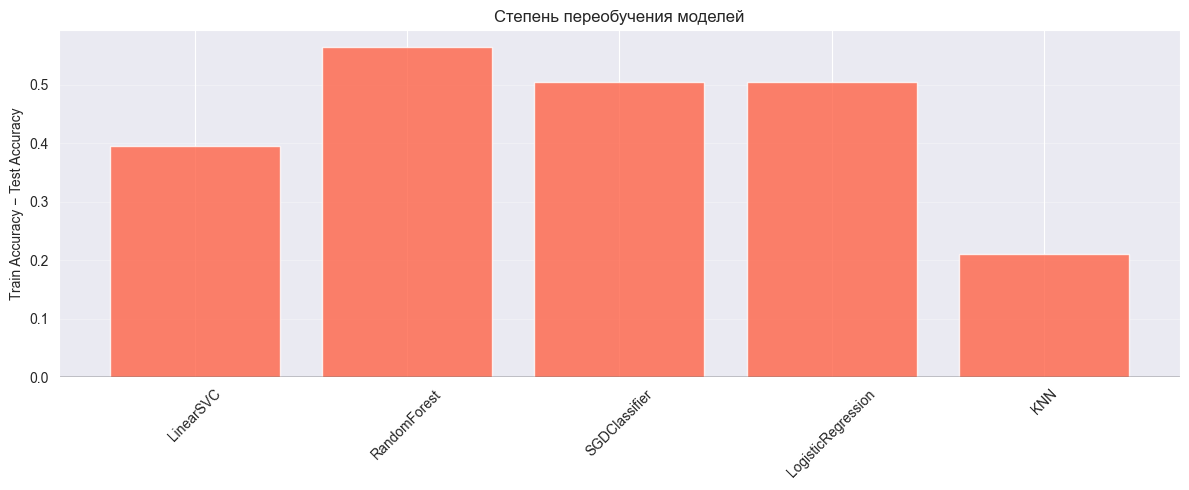

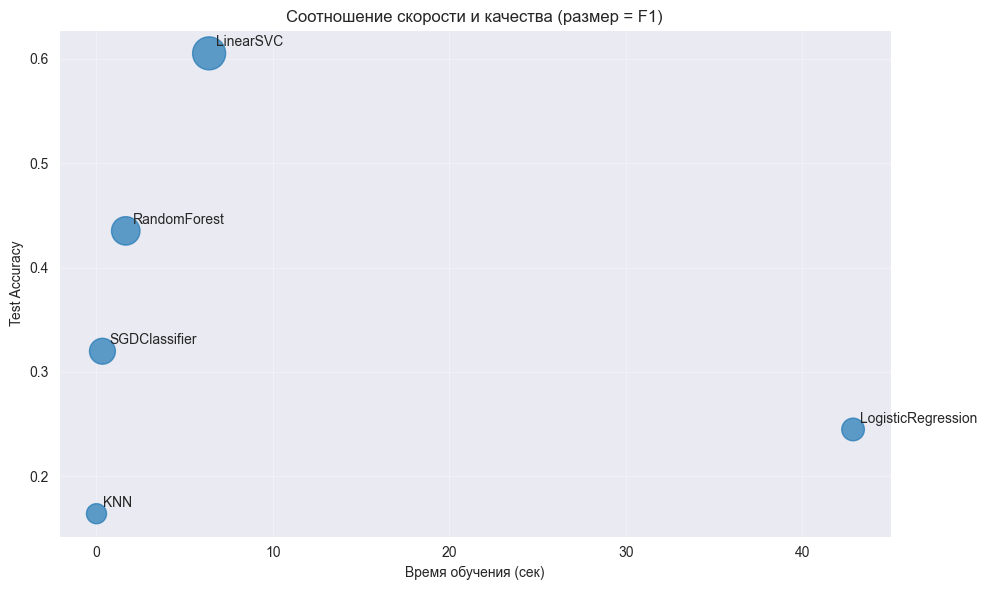

In [210]:
import matplotlib.pyplot as plt
import numpy as np

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12, 6))

plt.bar(x - width/2, results_df['Train_Accuracy'], width, label='Train Accuracy', alpha=0.7)
plt.bar(x + width/2, results_df['Test_Accuracy'], width, label='Test Accuracy', alpha=0.7)

plt.xticks(x, models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy по моделям')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

plt.bar(models, results_df['Overfitting_Accuracy'], color='tomato', alpha=0.8)
plt.axhline(0, color='black', linewidth=1)

plt.ylabel('Train Accuracy − Test Accuracy')
plt.title('Степень переобучения моделей')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

plt.scatter(
    results_df['Train_Time'],
    results_df['Test_Accuracy'],
    s=results_df['Test_F1'] * 800 + 100,
    alpha=0.7
)

for i, row in results_df.iterrows():
    plt.annotate(row['Model'],
                 (row['Train_Time'], row['Test_Accuracy']),
                 xytext=(5, 5),
                 textcoords='offset points')

plt.xlabel('Время обучения (сек)')
plt.ylabel('Test Accuracy')
plt.title('Соотношение скорости и качества (размер = F1)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Почему получились такие результаты
1) LinearSVC — 60.5%
a) Линейная модель идеально подходит для TF-IDF
b) Хорошо справляется с: авторским словарём, характерными биграммами
c) Не страдает от высокой размерности
d) TF-IDF + бинарные признаки рождают почти уникальные сигнатуры песен - 100% на train

2) RandomForest — 43.5%
a) TF-IDF = разреженное пространство, а RandomForest не любит разреженные данные
b) Деревья запоминают редкие слова, уникальные сочетания, припевные повторы  - 100% на train

3) SGDClassifier — 32%
a) Работает как приближённый LinearSVM
b) Быстрый, но менее стабильный
c) Менее точная оптимизация для нашей задачи

4) LogisticRegression — 25%, с запасом худший результат по времени
a) Очень много классов, softmax плохо сходится
b) Плохо справляется с мультиколлинеарностью, шумными словами
c) Долго обучается (saga + sparse)

5) KNN - 16.5%
Ожидаемо худший результат по точности, был добавлен скорее в качестве показательного учебного примера, расстояния в нашей задаче практически бессмысленны в текущем варианте решения

### Где возникают ошибки

                          artist  total_songs  correct  error_rate
41  Ежемесячные (Ezhemesyachnye)            6        0    1.000000
23                       PHARAOH            6        1    0.833333
30                   Thomas Mraz            6        1    0.833333
29                        T-Fest            6        1    0.833333
50       Слава КПСС (Slava KPSS)            6        1    0.833333
27                      SODA LUV            6        1    0.833333
24                        SALUKI            6        1    0.833333
26                  SLAVA MARLOW            6        1    0.833333
19                        Markul            6        2    0.666667
40                   Дора (Dora)            6        2    0.666667
38                 Баста (Basta)            6        2    0.666667
18                  MORGENSHTERN            6        2    0.666667
1                          25/17            6        2    0.666667
51           Смоки Мо (Smoky Mo)            6        2    0.66

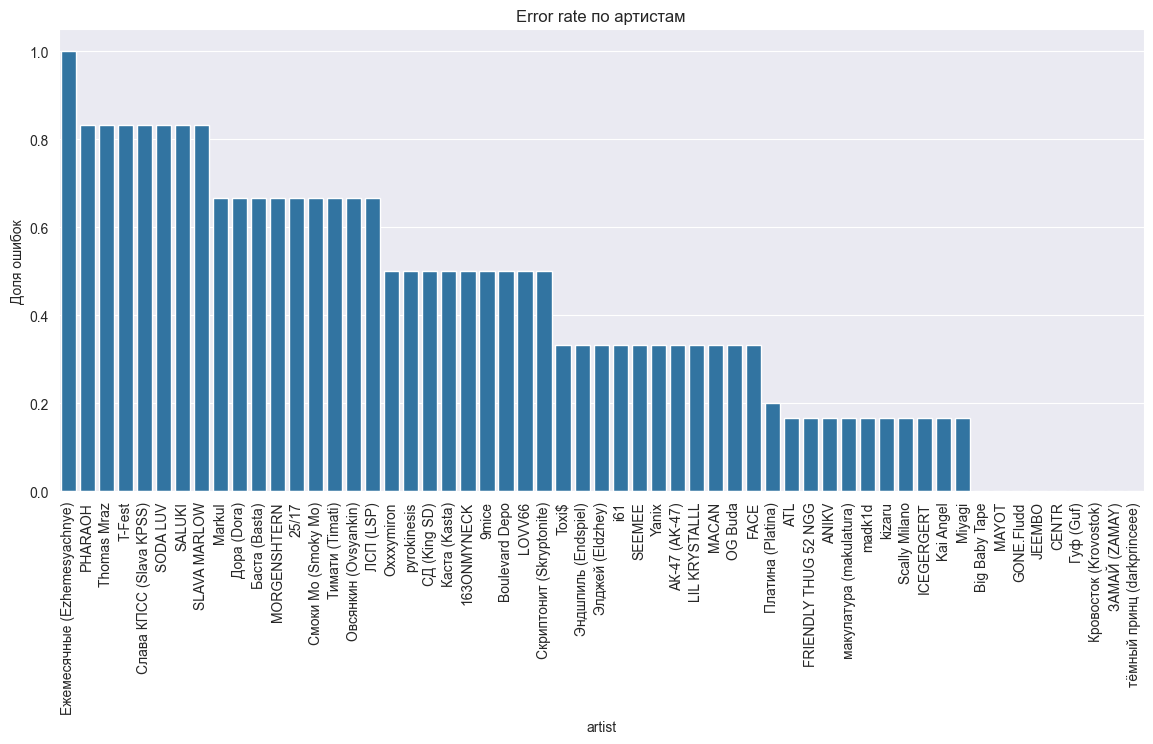


=== Top путаницы между артистами (по количеству ошибок) ===
Ежемесячные (Ezhemesyachnye) → СД (King SD): 2 ошибок
Скриптонит (Skryptonite) → Гуф (Guf): 2 ошибок
Тимати (Timati) → CENTR: 2 ошибок
СД (King SD) → ЗАМАЙ (ZAMAY): 2 ошибок
ЛСП (LSP) → Скриптонит (Skryptonite): 2 ошибок
T-Fest → Скриптонит (Skryptonite): 2 ошибок
Слава КПСС (Slava KPSS) → pyrokinesis: 2 ошибок
i61 → Boulevard Depo: 2 ошибок
163ONMYNECK → MAYOT: 2 ошибок
9mice → Kai Angel: 3 ошибок


In [226]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

best_model = models['LinearSVC']
y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=best_model.classes_)

correct_counts = np.diag(cm)
total_counts = cm.sum(axis=1)
error_rate = 1 - correct_counts / total_counts

artist_error_df = pd.DataFrame({
    'artist': best_model.classes_,
    'total_songs': total_counts,
    'correct': correct_counts,
    'error_rate': error_rate
})

print(artist_error_df.sort_values('error_rate', ascending=False))

plt.figure(figsize=(14,6))
sns.barplot(x='artist', y='error_rate', data=artist_error_df.sort_values('error_rate', ascending=False))
plt.xticks(rotation=90)
plt.ylabel('Доля ошибок')
plt.title('Error rate по артистам')
plt.show()

cm_offdiag = cm.copy()
np.fill_diagonal(cm_offdiag, 0)

top_errors_idx = np.unravel_index(np.argsort(cm_offdiag, axis=None)[-10:], cm_offdiag.shape)

print("\n=== Top путаницы между артистами (по количеству ошибок) ===")
for i,j in zip(*top_errors_idx):
    if cm_offdiag[i,j] > 0:
        print(f"{best_model.classes_[i]} → {best_model.classes_[j]}: {cm_offdiag[i,j]} ошибок")

Самые частые ошибки зачастую между схожими артистами, имеющими много совместных работ, которые в текущей версии проекта причислялись только к одному исполнителю. Даже по ошибкам можно понять, что модель усваивает общий стиль артиста